In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define NASA polynomial cofficients
nasa_dict = {
    "H" : {"low" : [0.000000000E+00, 0.000000000E+00, 2.500000000E+00, 0.000000000E+00, 0.000000000E+00, 
0.000000000E+00, 0.000000000E+00, 2.547370801E+04, -4.466828530E-01],
           "high" : [6.078774250E+01, -1.819354417E-01, 2.500211817E+00, -1.226512864E-07, 3.732876330E-11,
-5.687744560E-15, 3.410210197E-19, 2.547486398E+04, -4.481917770E-01]},
    "H2" : {"low" : [4.078323210E+04, -8.009186040E+02, 8.214702010E+00, -1.269714457E-02, 1.753605076E-05,
-1.202860270E-08, 3.368093490E-12, 2.682484665E+03, -3.043788844E+01],
            "high" : [5.608128010E+05, -8.371504740E+02, 2.975364532E+00, 1.252249124E-03, -3.740716190E-07,
 5.936625200E-11, -3.606994100E-15, 5.339824410E+03, -2.202774769E+00]}
}

R = 8.314
kb = 1.380649e-23

In [68]:
def nasa_polynomials(species, t):
    if t > 1000.:
        trange = "high"
    else:
        trange = "low"
        
    return nasa_dict[species][trange] 

def chemical_potential_rt(species, t):
    """
    Chemical potential for species at temperature T
    divided by RT
    """
    
    p = nasa_polynomials(species, t)

    mu = -p[0]*(t**-2)/2. + p[1]*(1.+np.log(t))/t +  \
    p[2]*(1.-np.log(t)) - p[3]*t/2. - p[4]*t**2/6. - \
    p[5]*t**3/12. - p[6]*t**4/20. + p[7]/t - p[8]
    
    return mu

def forward_rate(temperature, M):
    """
    Forward rate of reaction H + H + M -> H2 + M
    """
    
    k0 = 2.7e-31*temperature**-0.6
    kinf = 3.31e-6*temperature**-0.6
    
    kf = k0*M/(1.+(k0*M/kinf))
    
    return kf

def reverse_rate(temperature, M):
    """
    Reverse rate of reaction H + H + M -> H2 + M
    """
    
    gibbs_reaction_rt = gibbs_energy_of_reaction_rt(temperature)
    kf = forward_rate(temperature, M)
    
    kr = kf*(kb*temperature)**(-1)/np.exp(-gibbs_reaction_rt)
    
    return kr

    
def gibbs_energy_of_reaction_rt(temperature):
    """
    Gibbs energy of reaction for H + H -> H2
    """
    
    muh2 = chemical_potential_rt("H2", temperature)
    muh = chemical_potential_rt("H", temperature)
    
    gibbs_reaction_rt = muh2 - muh - muh
    
    return gibbs_reaction_rt

In [71]:
pressure = 1e4 # Pa
temperature = 3200. # K
number_density = pressure/kb/temperature/100**3 # cm-3

J = 0.
nhtot = 2.*number_density


tol = 1e-2

NSTEPS = 50000

DTINT = 1e-20 # s
DTMAX = 1e1 # s

4.819927526619779e-16 864.0567063150787
3.902038941939089e+17 2.263428286262475e+17 0.15432530445838663 0.8456746955416133


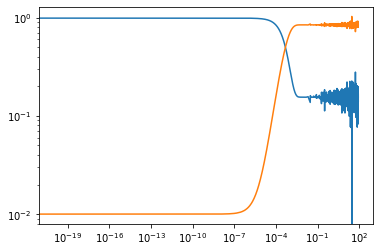

In [72]:
nh = np.zeros(NSTEPS)
nh2 = np.zeros(NSTEPS)
time = np.zeros(NSTEPS)

dt = DTINT

kf = forward_rate(temperature, number_density)
kr = reverse_rate(temperature, number_density)
print(kf, kr)

nh2[0] = 0.99*number_density
nh[0] = 0.01*number_density

for i in range(1,NSTEPS):
    nh2[i] = dt*(-J*nh2[i-1] + kf*nh[i-1]*nh[i-1] - kr*nh2[i-1]) + nh2[i-1]
    nh[i] = dt*(2*J*nh2[i-1] + 2*kr*nh2[i-1] - 2*kf*nh[i-1]*nh[i-1]) + nh[i-1]
    time[i] = time[i-1] + dt
    
    if nh2[i-1] > 0.:
        dnh2 = abs((nh2[i] - nh2[i-1])/nh2[i-1])
    if nh[i-1] > 0.:
        dnh = abs((nh[i] - nh[i-1])/nh[i-1])
    dn = max(dnh2, dnh)

    # Timestep control
    if dn > tol:
        dt = dt*0.1
    else:
        dt = dt*1.5
    if dt > DTMAX:
        dt = DTMAX
        
    #print(dn, dt)

print(nh2[-1]+nh[-1], number_density, nh2[-1]/(nh2[-1]+nh[-1]), nh[-1]/(nh2[-1]+nh[-1]))
plt.plot(time, nh2/(nh2+nh))
plt.plot(time, nh/(nh2+nh))
plt.yscale('log')
plt.xscale('log')




In [ ]:
# Heated box
P = 100 # Pa
R = 8.314 
V = 1. #m3
A = 1. #m2
mu = 1.5e-3 #kg/mol
cp = 15e3 # J/kg/K
sigma = 5.670374419e-8
H = 0.#5000. # W/m2

Tinit = 1000.

T = np.zeros(NSTEPS)
time =np.zeros(NSTEPS)
T[0] = Tinit
timestep = 100.
for i in range(1,NSTEPS):
    T[i] = timestep*(P*V/(R*T[i-1])*mu*A/cp*(H-sigma*T[i-1]**4)) + T[i-1]
    
    time[i] = time[i-1] + timestep
    
    dT = abs((T[i] - T[i-1])/timestep)
    
    
    if dT > tol:
        timestep = timestep*0.1
    else:
        timestep = timestep * 1.1
    if timestep > 1e5:
        timestep = 1e5

plt.plot(time, T)